In [1]:
# notebook last tested with abtem version 1.0.0beta13

from abtem import __version__
print('current version:', __version__)

from ase.io import read
import matplotlib.pyplot as plt

from abtem import *
from abtem.utils import ProgressBar

current version: 1.0.0beta28


# PACBED thickness series (no PRISM)

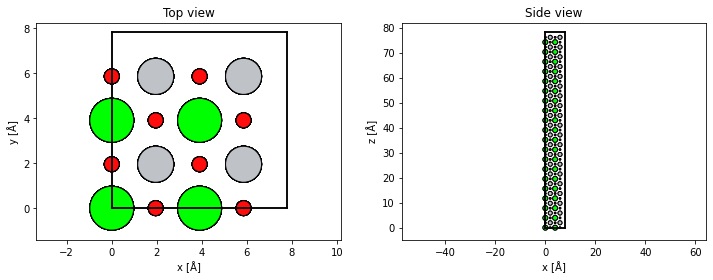

In [2]:
atoms = read('../data/srtio3_100.cif')

atoms *= (2, 2, 20)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view');

In [3]:
potential = Potential(atoms, 
                  gpts=128, 
                  device='cpu', 
                  projection='infinite', 
                  slice_thickness=.5, 
                  parametrization='kirkland')

In [4]:
probe = Probe(energy=80e3, semiangle_cutoff=20, device='cpu')
probe.grid.match(potential)

scan = GridScan(start=[0, 0], end=potential.extent, sampling=.9*probe.ctf.nyquist_sampling)

detectors = [PixelatedDetector(max_angle=60), AnnularDetector(inner=40, outer=150)]

In [5]:
# save after every eighth slice
save_every = 4

chunks = [(i, i + save_every) for i in range(0, len(potential), save_every)]

In [7]:
# Allocate on measurement for each detector for each output thickness
measurements = [probe.validate_scan_measurements(detectors, scan) for chunk in chunks]

max_batch = 50 # propagate 50 probes at a time, lower or increase this based on memory

fp = FrozenPhonons(atoms, sigmas=.5, num_configs=4)
fp_pbar = ProgressBar(desc='Frozen phonons', total=len(fp))
pbar = ProgressBar(desc='Positions', total=len(scan))

for atoms in fp:
    pbar.reset()
    potential = Potential(atoms, 
                      gpts=128, 
                      device='cpu', 
                      projection='infinite', 
                      slice_thickness=atoms.cell[2,2] / 80, 
                      parametrization='kirkland')

    for indices, positions in scan.generate_positions(max_batch=max_batch):
        waves = probe.build(positions)

        for chunk_idx, (start_slice, end_slice) in enumerate(chunks):
            potential_slices = potential[start_slice:end_slice]
            waves = waves.multislice(potential_slices, pbar=False)

            for detector in detectors:
                new_measurements = detector.detect(waves)
                scan.insert_new_measurement(measurements[chunk_idx][detector], indices, new_measurements)

        pbar.update(len(positions))
    
    fp_pbar.update(1)

pbar.close()
fp_pbar.close()

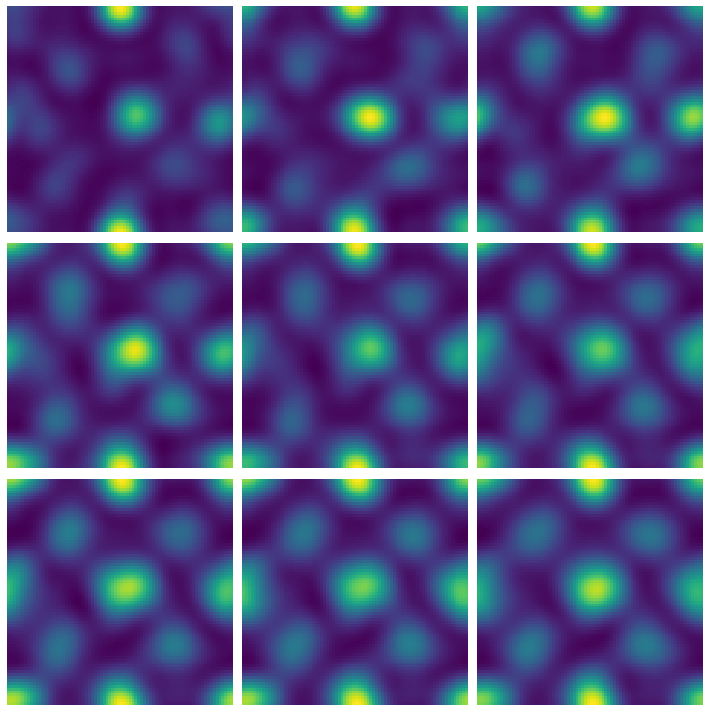

In [8]:
fig, axes = plt.subplots(3,3, figsize=(10,10))

for i, ax in enumerate(axes.ravel()):
    measurements[i][detectors[1]].interpolate(.1).show(ax=ax, cmap='viridis', power=1, title='')
    ax.axis('off')

plt.tight_layout()

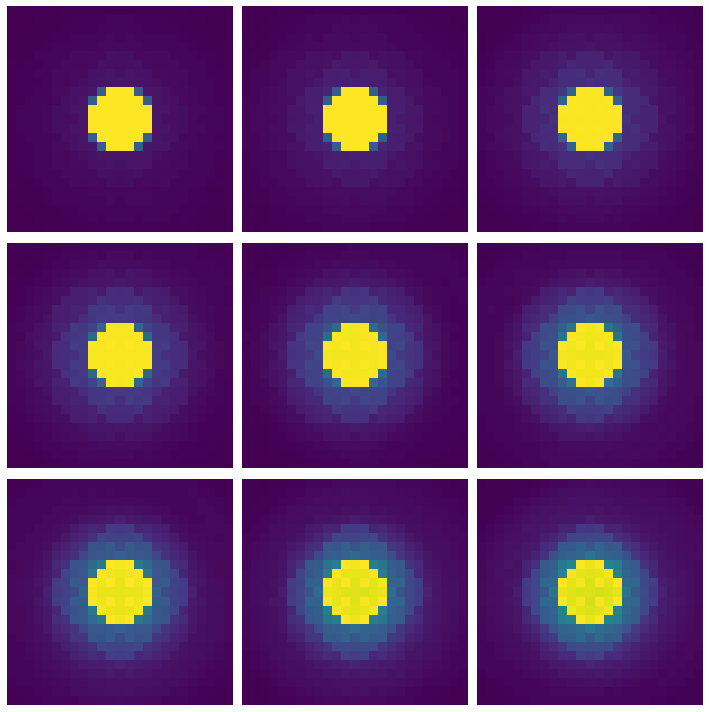

In [9]:
fig, axes = plt.subplots(3,3, figsize=(10,10))

for i, ax in enumerate(axes.ravel()):
    measurements[i][detectors[0]].sum((0,1)).show(ax=ax, cmap='viridis', power=.5, title='')
    ax.axis('off')

plt.tight_layout()